# Deep Learning Homework 5: Two Layer Neural Network (A Toy Data)

We divide the two-layer neural network (NN) assignment into two parts, HW5 and HW6. In HW5, you will implement your first NN and train it on a toy data set. This data set is simple and easy to train. Therefore, it will help you better understand the forward and backward processes of the NN. Please keep your codes that will be used in HW6.

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['two_layer_net.ipynb', 'a2_helpers.py', 'two_layer_net.py', 'usefuns']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022DL folder and put all the files under A0 folder, then '2022DL/A0'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2022DL/A0'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/DL_2024_Spring/HW5' # Please change to your folder
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['a2_helpers.py', 'usefuns', '__pycache__', 'two_layer_net.py', 'linear_classifier.py', 'svm_best_model.pt', 'softmax_best_model.pt', 'two_layer_net.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from two_layer_net.py!
Hello from a2_helpers.py!
```

as well as the last edit time for the file `two_layer_net.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "UTC"
time.tzset()

from two_layer_net import hello_two_layer_net
hello_two_layer_net()

from a2_helpers import hello_helper
hello_helper()

two_layer_net_path = os.path.join(GOOGLE_DRIVE_PATH, 'two_layer_net.py')
two_layer_net_edit_time = time.ctime(os.path.getmtime(two_layer_net_path))
print('two_layer_net.py last edited on %s' % two_layer_net_edit_time)

Hello from two_layer_net.py!
Hello from a2_helpers.py!
two_layer_net.py last edited on Sun Mar 24 19:50:29 2024


## Miscellaneous

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import usefuns
import torch
import matplotlib.pyplot as plt
import statistics
import random
import time
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

We train the network with a softmax loss function and L2 regularization on the weight matrices. The network uses a ReLU nonlinearity after the first fully connected layer.

In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class.

**Note**: When you implment the regularization over W, **please DO NOT multiply the regularization term by 1/2** (no coefficient).






## Play with a toy data

The inputs to our network will be a batch of $N$ (`num_inputs`) $D$-dimensional vectors (`input_size`); the hidden layer will have $H$ hidden units (`hidden_size`), and we will predict classification scores for $C$ categories (`num_classes`). This means that the learnable weights and biases of the network will have the following shapes:

*   W1: First layer weights; has shape (D, H)
*   b1: First layer biases; has shape (H,)
*   W2: Second layer weights; has shape (H, C)
*   b2: Second layer biases; has shape (C,)

We will use `a2_helpers.get_toy_data` function to generate random weights for a small toy model while we implement the model.

### Forward pass: compute scores
Like in the Linear Classifiers exercise, we want to write a function that takes as input the model weights and a batch of images and labels, and returns the loss and the gradient of the loss with respect to each model parameter.

However rather than attempting to implement the entire function at once, we will take a staged approach and ask you to implement the full forward and backward pass one step at a time.

First we will implement the forward pass of the network which uses the weights and biases to compute scores for all inputs in `nn_forward_pass`.

**Hint**: you can use `torch.clamp` to implement ReLU.

Compute the scores and compare with the answer. The distance gap should be smaller than 1e-10.

In [7]:
import usefuns
from a2_helpers import get_toy_data
from two_layer_net import nn_forward_pass

usefuns.reset_seed(0)
toy_X, toy_y, params = get_toy_data()

# YOUR_TURN: Implement the score computation part of nn_forward_pass
scores, _ = nn_forward_pass(params, toy_X)
print('Your scores:')
print(scores)
print(scores.dtype)
print()
print('correct scores:')
correct_scores = torch.tensor([
        [ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], dtype=torch.float32, device=scores.device)
print(correct_scores)
print()

# The difference should be very small. We get < 1e-10
scores_diff = (scores - correct_scores).abs().sum().item()
print('Difference between your scores and correct scores: %.2e' % scores_diff)

Your scores:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], device='cuda:0')
torch.float32

correct scores:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], device='cuda:0')

Difference between your scores and correct scores: 2.24e-11


### Forward pass: compute loss
Now, we implement the first part of `nn_forward_backward` that computes the data and regularization loss.

For the data loss, we will use the softmax loss. For the regularization loss we will use L2 regularization on the weight matrices `W1` and `W2`; we will not apply regularization loss to the bias vectors `b1` and `b2`.

First, Let's run the following to check your implementation.

We compute the loss for the toy data, and compare with the answer computed by our implementation. The difference between the correct and computed loss should be less than `1e-4`.

In [8]:
import usefuns
from a2_helpers import get_toy_data
from two_layer_net import nn_forward_backward

usefuns.reset_seed(0)
toy_X, toy_y, params = get_toy_data()

# YOUR_TURN: Implement the loss computation part of nn_forward_backward
loss, _ = nn_forward_backward(params, toy_X, toy_y, reg=0.05)
print('Your loss: ', loss.item())
correct_loss = 1.0986121892929077
print('Correct loss: ', correct_loss)
diff = (correct_loss - loss).item()

# should be very small, we get < 1e-4
print('Difference: %.4e' % diff)

Your loss:  1.0986121892929077
Correct loss:  1.0986121892929077
Difference: 0.0000e+00


### Backward pass
Now implement the backward pass for the entire network in `nn_forward_backward`.

After doing so, we will use numeric gradient checking to see whether the analytic gradient computed by our backward pass mateches a numeric gradient.

We will use the functions `usefuns.grad.compute_numeric_gradient` and `usefuns.grad.rel_error` to help with numeric gradient checking. We can learn more about these functions using the `help` command:


In [9]:
help(usefuns.grad.compute_numeric_gradient)
print('-' * 80)
help(usefuns.grad.rel_error)

Help on function compute_numeric_gradient in module usefuns.grad:

compute_numeric_gradient(f, x, h=1e-07)
    Compute the numeric gradient of f at x using a finite differences
    approximation. We use the centered difference:
    
    df    f(x + h) - f(x - h)
    -- ~= -------------------
    dx           2 * h
    
    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor giving the point at which to compute the gradient
    
    Returns:
    - grad: A tensor of the same shape as x giving the gradient of f at x

--------------------------------------------------------------------------------
Help on function rel_error in module usefuns.grad:

rel_error(x, y, eps=1e-10)
    Compute the relative error between a pair of tensors x and y,
    which is defined as:
    
                            max_i |x_i - y_i]|
    rel_error(x, y) = -------------------------------
                      max_i |x_i| + max_i |y_i| + eps
    
    Inputs

Now we will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check.

You should see relative errors less than `1e-4` for all parameters.

In [10]:
import usefuns
from a2_helpers import get_toy_data
from two_layer_net import nn_forward_backward

usefuns.reset_seed(0)

reg = 0.05
toy_X, toy_y, params = get_toy_data(dtype=torch.float64)

# YOUR_TURN: Implement the gradient computation part of nn_forward_backward
#            When you implement the gradient computation part, you may need to
#            implement the `hidden` output in nn_forward_pass, as well.
loss, grads = nn_forward_backward(params, toy_X, toy_y, reg=reg)

for param_name, grad in grads.items():
  param = params[param_name]
  f = lambda w: nn_forward_backward(params, toy_X, toy_y, reg=reg)[0]
  grad_numeric = usefuns.grad.compute_numeric_gradient(f, param)
  error = usefuns.grad.rel_error(grad, grad_numeric)
  print('%s max relative error: %e' % (param_name, error))

W2 max relative error: 1.474277e-06
b2 max relative error: 5.564052e-09
W1 max relative error: 1.494314e-06
b1 max relative error: 8.000310e-06


### Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers.

Look at the function `nn_train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers.

You will also have to implement `nn_predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. Your final training loss should be less than 1.0.

Final training loss:  0.5211756229400635


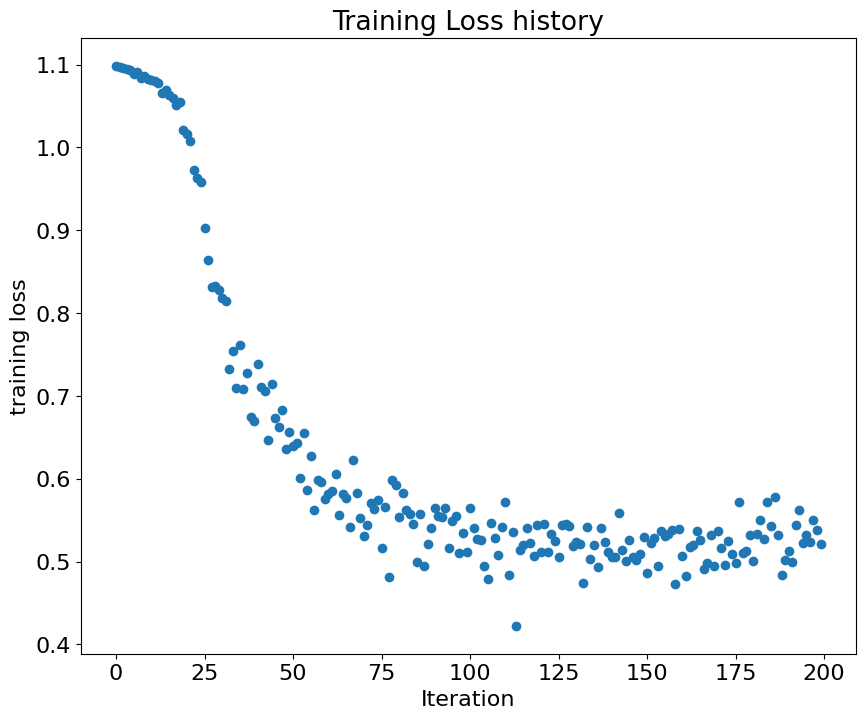

In [11]:
import usefuns
from a2_helpers import get_toy_data
from two_layer_net import nn_forward_backward, nn_train, nn_predict

usefuns.reset_seed(0)
toy_X, toy_y, params = get_toy_data()

# YOUR_TURN: Implement the nn_train function.
#            You may need to check nn_predict function (the "pred_func") as well.
stats = nn_train(params, nn_forward_backward, nn_predict, toy_X, toy_y, toy_X, toy_y,
                 learning_rate=1e-1, reg=1e-6,
                 num_iters=200, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'], 'o')
plt.xlabel('Iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

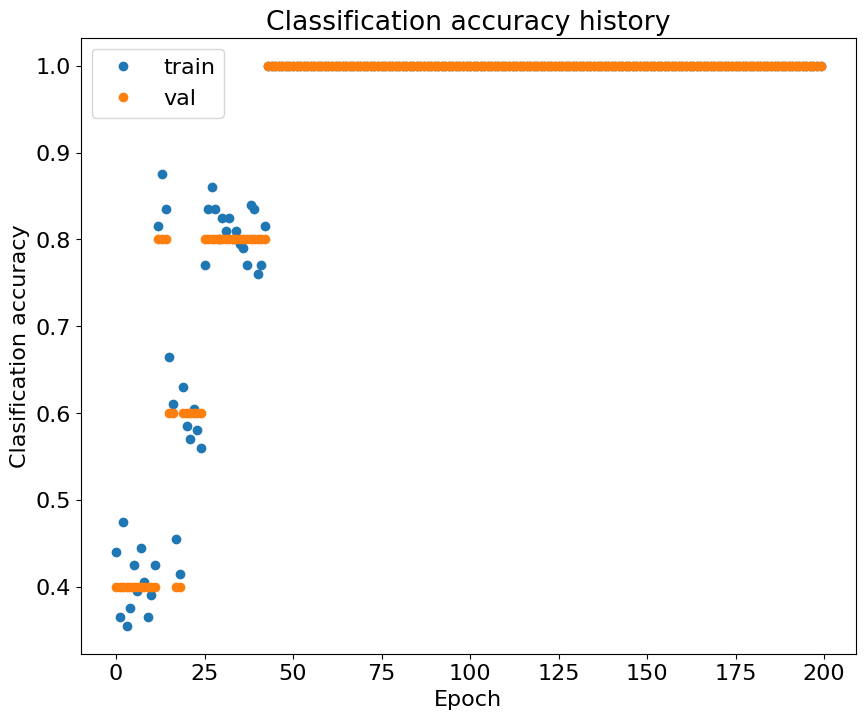

In [12]:
# Plot the loss function and train / validation accuracies
plt.plot(stats['train_acc_history'], 'o', label='train')
plt.plot(stats['val_acc_history'], 'o', label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()